# Dynesty - fitting real Kepler light curves

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# from tqdm import tqdm
# from astropy.table import Table
# import astropy.units as u
# import scipy
# from scipy import signal


from astropy.io import fits

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares

import dynesty

# And importing `photoeccentric`
import photoeccentric as ph

# # Random stuff
import scipy.constants as c
import os

import random

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
nwalk = 64
nsteps_d = 1500
ndiscard_d = 1000
arrlen = (nsteps_d-ndiscard_d)*nwalk

In [73]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## Reading in Sample Data

In [74]:
spectplanets = pd.read_csv('datafiles2/spectplanets.csv')
muirhead_comb = pd.read_csv('datafiles2/muirhead_comb.csv')
muirhead_comb_lums = pd.read_csv('datafiles2/muirhead_comb_lums.csv')
muirhead_lamost = pd.read_csv('datafiles2/muirhead_lamost.csv')
muirheadKOIs = pd.read_csv('datafiles2/MuirheadKOIs.csv')

In [75]:
KOI = 1867

In [76]:
kepid = muirhead_comb[muirhead_comb['KOI'] == str(KOI)].KIC.item()

In [77]:
kepid = int(kepid)

In [78]:
kepoiname = spectplanets.loc[spectplanets['kepid'] == float(kepid)].kepoi_name.values[0]

In [79]:
mpts = pd.read_csv('datafiles2/tmidpoints_new.csv')

In [166]:
def get_lc_files(KIC, KICs, lcpath):

    lclist = []

    for i in range(len(KICs)):
        templst = []
        for subdir, dirs, files in os.walk(lcpath):
            for file in files:
                #print(str(int(KICs[i])))
                #print(file)
                if str(int(KICs[i])) in file:
                    templst.append(os.path.join(subdir, file))
        lclist.append(templst)


    files = lclist[int(np.argwhere(KICs==KIC))]

    return files



def sigma_clip(time, flux, fluxerr, sig=4):
    for i in tqdm(range(len(flux))):
        if flux[i] > np.nanmean(flux) + sig*np.nanstd(flux) or flux[i] < np.nanmean(flux) - sig*np.nanstd(flux):
            time[i] = np.nan
            flux[i] = np.nan
            fluxerr[i] = np.nan
            
    return time, flux, fluxerr
            

In [167]:
lcpath = '/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/datafiles/sample_LCs/'
KICs = np.sort(np.unique(np.array(muirhead_comb['KIC'])))
KICs = np.array([7870390])
KIC = 7870390
kepid = KIC
NKOI = 898
KOI = 'KOI 898'

files = get_lc_files(KIC, KICs, lcpath)

In [168]:
hdus, t, f, fe, starts, stops = ph.get_stitched_lcs(files, KIC)

In [169]:
alltime_noclip = []
allflux_noclip = []
allfluxerr_noclip = []

for sublist in t:
    for item in sublist:
        alltime_noclip.append(item)
        
for sublist in f:
    for item in sublist:
        allflux_noclip.append(item)
        
for sublist in fe:
    for item in sublist:
        allfluxerr_noclip.append(item)

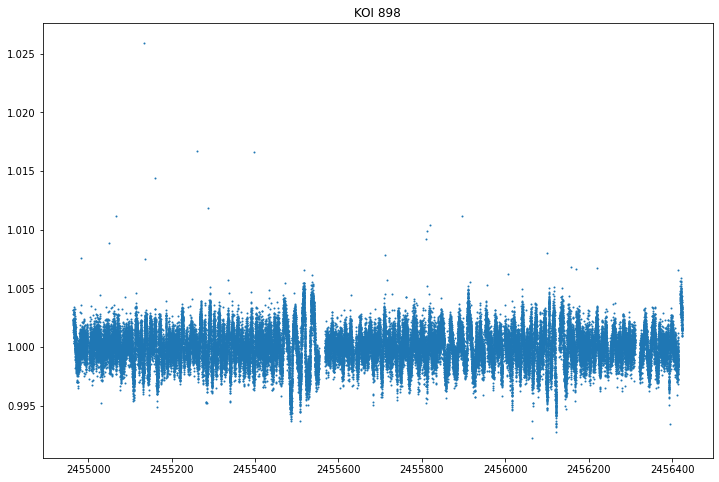

In [170]:
# alltime, allflux, allfluxerr = sigma_clip(alltime_noclip, allflux_noclip, allfluxerr_noclip, sig=4)

time, flux, flux_err = np.array(alltime_noclip), np.array(allflux_noclip), np.array(allfluxerr_noclip)

plt.scatter(time, flux, s=1)
plt.title('KOI '+ str(NKOI))

plt.ticklabel_format(useOffset=False, style='plain')

# KOI 898

In [171]:
#kepid = 9710326
#kepid = 9730163
#kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]

In [172]:
spectplanets.loc[spectplanets['kepid'] == kepid]

,Unnamed: 0,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
12,240,7870390,K00898.01,Kepler-83 A b,CONFIRMED,Done,8/16/18,CANDIDATE,1.0,0,...,-0.13,0.13,0.13,0.12,0.029,0.10,-0.08,0.14,0.08,0.15
13,241,7870390,K00898.02,Kepler-83 A d,CONFIRMED,Done,8/16/18,CANDIDATE,1.0,0,...,-0.01,0.15,0.05,0.12,0.000,0.12,0.12,0.15,0.12,0.15
14,243,7870390,K00898.03,Kepler-83 A c,CONFIRMED,Done,8/16/18,CANDIDATE,1.0,0,...,0.06,0.14,0.17,0.14,0.150,0.14,0.11,0.14,0.19,0.14


In [173]:
isodf = pd.read_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

In [174]:
mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

In [175]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepoiname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((abs(a_uerr_arc), abs(a_lerr_arc)))

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
print('Period (Days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

Stellar mass (Msun):  0.5280873155275195 Stellar radius (Rsun):  0.5132036306020795
Period (Days):  2.549562652 Rp/Rs:  0.020119
a/Rs:  12.358554115112359
i (deg):  89.77


In [176]:
perioderr = np.nanmean((abs(period_uerr), abs(period_lerr)))
rprserr = np.nanmean((abs(rprs_uerr), abs(rprs_lerr)))

In [177]:
# TODO: Take midpoints from csv files

#mpts = pd.read_csv('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/datafiles/keplerstellar/sampleIDs/transitmidtimes.csv', comment='#')

In [178]:
#transitmpt = mpts.loc[mpts['KOI (star)'] == NKOI]['Transit Epoch (BJD)'].values[0]

In [179]:
mpts = pd.read_csv('tmidpoints_new.csv')

In [180]:
midpoints = np.concatenate((np.arange(transitmpt, starts[0], -period), np.arange(transitmpt, stops[-1], period)))

In [181]:
#ph.remove_oot_data(time, flux, flux_err, midpoints)

In [207]:
timez = []
fluxez = []
ferrz = []

for i in range(len(midpoints)):
    
    try:
        m, b, t1bjd, t1, fnorm, fe1 = ph.do_linfit(time, flux, flux_err, midpoints[i], 11, 5)
        timez.append(t1bjd)
        fluxez.append(fnorm)
        ferrz.append(fe1)

    except TypeError:
        continue
        
ttimes = np.array(timez).flatten()
tfluxes = np.array(fluxez).flatten()
tferr = np.array(ferrz).flatten()

ttimes = np.hstack(ttimes)
tfluxes = np.hstack(tfluxes)
tferr = np.hstack(tferr)

tfluxes = np.nan_to_num(tfluxes, nan=1.0)
#tferr = np.nan_to_num(tferr, nan=np.nanmedian(tferr))
tferr = np.nan_to_num(tferr, nan=0.00064)


<ipython-input-207-84d8735cd4c4>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ttimes = np.array(timez).flatten()
<ipython-input-207-84d8735cd4c4>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tfluxes = np.array(fluxez).flatten()
<ipython-input-207-84d8735cd4c4>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tferr = np.ar

<ErrorbarContainer object of 3 artists>

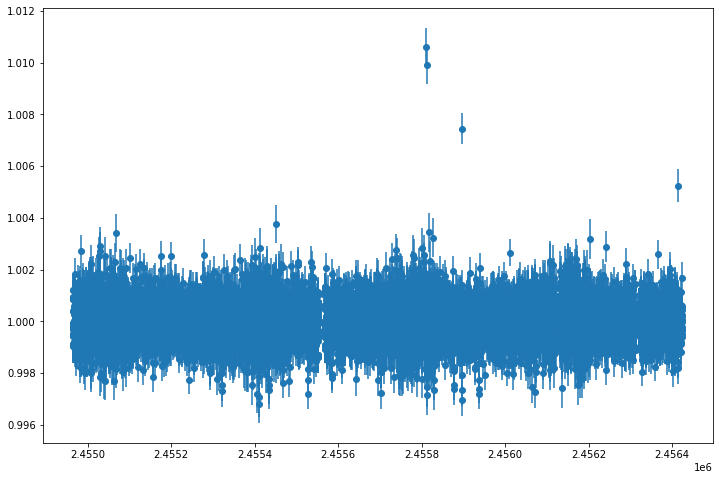

In [211]:
plt.errorbar(ttimes, tfluxes, yerr=tferr, fmt='o')
#plt.xlim(ttimes[0], ttimes[20])
#plt.ylim(0.9980, 1.0005)

In [212]:
def get_KIC(KOI, muirhead_comb):
    return muirhead_comb[muirhead_comb['KOI'] == str(KOI)].KIC.item()

In [213]:
KOI

'KOI 898'

In [214]:
muirhead_comb[muirhead_comb['KOI'] == '898']

,Unnamed: 0,KOI,KIC,Teff,ETeff,eTeff,Fe/H,e_Fe/H,M/H,e_M/H,...,mass_err2,prov_sec,nconfp,nkoi,ntce,jmag,hmag,kmag,planet?,kepler_gaia_ang_dist
81,84,898,7870390,3907,94,106,-0.33,0.13,-0.24,0.13,...,-0.033,b'DSEP',3,3,3,13.737,13.079,12.947,b'conf',0.018808


In [215]:
priortransform = [10*perioderr, period-((10*perioderr)/2.), 10*rprserr, rprs-((10*rprserr)/2.), 10*a_rs_err, a_rs-((10*a_rs_err)/2.), 0.5, i-(0.5/2.), 0.01, transitmpt-(0.01/2)]

In [216]:
priortransform

[3.74e-05,
 2.549543952,
 0.0049949999999999994,
 0.017621500000000002,
 8.11,
 8.303554115112359,
 0.5,
 572.75,
 0.01,
 2454965.60303]

In [ ]:
nbuffer=11
dres, pdist, rdist, adist, idist, t0dist = ph.fit_keplc_dynesty(KOI, midpoints, ttimes, tfluxes, tferr, priortransform, arrlen, nbuffer, spectplanets, muirhead_comb)

0it [00:00, ?it/s]

Stellar mass (Msun):  0.5280873155275195 Stellar radius (Rsun):  0.5132036306020795
Period (Days):  9.770448599999998 Rp/Rs:  0.040133
a/Rs:  30.26450260741742
i (deg):  89.84


In [ ]:
np.savetxt('periods.csv', perDists, delimiter=',')
np.savetxt('rprs.csv', rpDists, delimiter=',')
np.savetxt('ars.csv', arsDists, delimiter=',')
np.savetxt('inc.csv', incDists, delimiter=',')

np.savetxt('t0.csv', t0Dists, delimiter=',')

# Example of fitting (e,w) for KOI 947: Using 11/30+ transit fits, averaged

In [ ]:
# First 10 transit fits from Kepler LC light curves, fit using dynesty
# In ph_segfits folder

pdist = [period]*11
rdist = [0.03, 0.04, 0.04, 0.03, 0.03, 0.04, 0.04, 0.03, 0.03, 0.04, 0.03]
adist = [70.73, 67.10, 65,68, 72.00, 66.76, 65.44, 64.69, 65.29, 64.24, 70.49, 65.02]
idist = [89.76, 89.9, 89.9, 89.58, 89.82, 89.86, 89.93, 89.90, 89.92, 89.84, 89.87]

In [ ]:
rho_star, mass, radius = ph.find_density_dist_symmetric(mstar, mstar_err, rstar, rstar_err, arrlen)

In [ ]:
T14dist = ph.get_T14(pdist, rdist, adist, idist)
T14errs = ph.get_sigmas(T14dist)

T23dist = ph.get_T23(pdist, rdist, adist, idist)
T23errs = ph.get_sigmas(T23dist)

# Get $g$

In [ ]:
gs, rho_c = ph.get_g_distribution(rho_star, pdist, rdist, T14dist, T23dist)

g_mean = ph.mode(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

In [ ]:
g_mean

In [ ]:
g_sigma

In [ ]:
g = g_mean
gerr = g_sigma

# Dynesty (e,w) Fitting LIkelihood Functions

In [ ]:
ndim = 2

def loglike(theta):
    """The log-likelihood function."""

    w, e = theta
    
    model = (1+e*np.sin(w*(np.pi/180.)))/np.sqrt(1-e**2)
    sigma2 = gerr ** 2
    
    return -0.5 * np.sum((g - model) ** 2 / sigma2 + np.log(sigma2))

def unife_prior_transform(utheta):
    """Uniform eccentricity prior"""
    
    uw, ue = utheta
    w = 360.*uw-90.
    e = 1. * ue
    
    return w, e


def betae_prior_transform(utheta):
    """Uniform eccentricity prior"""
    
    uw, ue = utheta
    w = 360.*uw-90.
    
    a, b = 0.867, 3.03
    e = scipy.stats.beta.ppf(ue, a, b)
    
    return w, e

## Uniform Prior

In [ ]:
dsampler = dynesty.DynamicNestedSampler(loglike, unife_prior_transform, ndim=2, bound='multi', sample='rstagger')

In [ ]:
dsampler.run_nested()

In [ ]:
dres = dsampler.results

In [ ]:
from dynesty import plotting as dyplot

fig, axes = dyplot.cornerplot(dres, show_titles=True, title_kwargs={'y': 1.04}, labels=["w", "e"],
                              fig=plt.subplots(2, 2, figsize=(8, 8)))

## Beta-distribution Prior

In [ ]:
dsampler = dynesty.DynamicNestedSampler(loglike, betae_prior_transform, ndim=2, bound='multi', sample='rstagger')

In [ ]:
dsampler.run_nested()

In [ ]:
dres = dsampler.results

In [ ]:
fig, axes = dyplot.cornerplot(dres, show_titles=True, title_kwargs={'y': 1.04}, labels=["w", "e"],
                              fig=plt.subplots(2, 2, figsize=(8, 8)))